<a href="https://colab.research.google.com/github/tiffanyformosa/kdg/blob/forward_transfer/docs/tutorials/kdn_notebooks/KDN_PROG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install libraries

!rm -r kdg
!git clone --branch forward_transfer https://github.com/tiffanyformosa/kdg
!ls
!pip install kdg/.

In [ ]:
# import modules
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from kdg.kdn import *
from kdg.utils import *

from google.colab import drive
drive.mount('/content/gdrive')

## Set Up NN

In [ ]:
def getNN(dense_size, input_size, **kwargs):
    network_base = keras.Sequential()
    network_base.add(layers.Dense(dense_size, activation='relu', input_shape=(input_size,)))
    network_base.add(layers.Dense(dense_size, activation='relu'))
    network_base.add(layers.Dense(units=2, activation = 'softmax'))
    network_base.compile(**kwargs)
    return network_base

dense_layer_nodes = 5

# NN params
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
fit_kwargs = {"epochs": 150, "batch_size": 32, "verbose": 0}

### 45-Degree XOR

In [ ]:
#Get initial KDN
size = 200
overlap = 0.5
X1, y1 = generate_gaussian_parity(size, cluster_std=overlap)
X2, y2 = generate_gaussian_parity(size, cluster_std=overlap, angle_params = np.pi/4)
X1_trans, y1_trans = generate_gaussian_parity(size, cluster_std=overlap)
X2_trans, y2_trans = generate_gaussian_parity(size, cluster_std=overlap, angle_params = np.pi/4)
X1_test, y1_test = generate_gaussian_parity(size, cluster_std=overlap)
X2_test, y2_test = generate_gaussian_parity(size, cluster_std=overlap, angle_params = np.pi/4)

network_base = getNN(dense_layer_nodes, 2, **compile_kwargs)

transfer_kdn = kdn(network = network_base,
                   optimizer = keras.optimizers.Adam(3e-4),
                   loss = "binary_crossentropy")
transfer_kdn.fit(X1, y1, "XOR", **fit_kwargs)
transfer_kdn.fit(X2, y2, "RXOR", **fit_kwargs)

In [ ]:
xor = np.mean(transfer_kdn.predict(X1_test, "XOR") == y1_test)
print(f"XOR accuracy: {xor}")
rxor = np.mean(transfer_kdn.predict(X2_test, "RXOR") == y2_test)
print(f"RXOR accuracy: {rxor}")

XOR accuracy: 0.705
RXOR accuracy: 0.725


In [ ]:
transfer_kdn.forward_transfer(X1_trans, y1_trans, "XOR")
xor_transfer = np.mean(transfer_kdn.predict(X1_test, "XOR") == y1_test)
print(f"XOR accuracy: {xor_transfer}")

transfer_kdn.forward_transfer(X2_trans, y2_trans, "RXOR")
rxor_transfer = np.mean(transfer_kdn.predict(X2_test, "RXOR") == y2_test)
print(f"RXOR accuracy: {rxor_transfer}")

XOR accuracy: 0.72
RXOR accuracy: 0.71


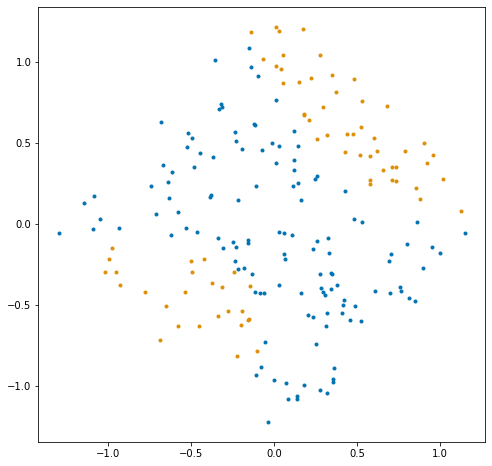

In [ ]:
plot_2dsim(X2_test, transfer_kdn.predict(X2_test, "XOR"))

## Proglearn Figures

### Functions

In [ ]:
#Modified Proglearn functions for running KDN_FT
def run(mc_rep, n_test, n_nodes, n_xor, n_rxor,
        mean_error, std_error, mean_te, std_te, overlap,
        task2_angle, task2_id):
    for i, n1 in enumerate(n_xor):
        print(f'starting to compute {n1} xor')
        error = Parallel(n_jobs = 2)(delayed(experiment)(n1, 0, task2_angle = task2_angle, overlap=overlap) for _ in range(mc_rep))
        error = np.array(error)
        mean_error[:, i] = np.mean(error, axis=0)
        std_error[:, i] = np.std(error, ddof=1, axis=0)
        mean_te[0, i] = np.mean(error[:, 0]) / np.mean(error[:, 1])
        mean_te[1, i] = np.mean(error[:, 2]) / np.mean(error[:, 3])
        mean_te[2, i] = np.mean(error[:, 0]) / np.mean(error[:, 4])
        mean_te[3, i] = np.mean(error[:, 2]) / np.mean(error[:, 5])

        if n1 == n_xor[-1]:
            for j, n2 in enumerate(n_rxor):
                print(f'starting to compute {n2} {task2_id}')
                error = Parallel(n_jobs = 2)(delayed(experiment)(n1, n2, task2_angle = task2_angle, overlap=overlap) for _ in range(mc_rep))
                error = np.array(error)
                #error = np.array([experiment(n1, n2, task2_angle = task2_angle, overlap=overlap) for _ in range(mc_rep)])

                mean_error[:, i + j + 1] = np.mean(error, axis=0)
                std_error[:, i + j + 1] = np.std(error, ddof=1, axis=0)
                mean_te[0, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 1])
                mean_te[1, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 3])
                mean_te[2, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 4])
                mean_te[3, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 5])

    return mean_error, std_error, mean_te, std_te


def experiment(
    n_task1,
    n_task2,
    n_test=1000,
    task1_angle=0,
    task2_angle=np.pi / 4,
    overlap = 0.25,
    task1_id="Task1",
    task2_id="Task2",
    dense_layer_nodes = 5,
    bagging = False,
    ideal_transfer = False,
    random_state=None,
):

    """
    A function to do KDN-FT experiment between two tasks
    where the task data is generated using Gaussian parity.
    Parameters
    ----------
    n_task1 : int
        Total number of train sample for task 1.
    n_task2 : int
        Total number of train dsample for task 2
    n_test : int, optional (default=1000)
        Number of test sample for each task.
    task1_angle : float, optional (default=0)
        Angle in radian for task 1.
    task2_angle : float, optional (default=numpy.pi/4)
        Angle in radian for task 2.
    task1_id : str, optional (default="Task1")
        Name of Task 1
    task2_angle : float, optional (default="Task2")
        Name of Task 2
    dense_layer_nodes : int, optional (default=5)
        Controls size of neural network
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    errors : array of shape [6]
        Elements of the array is organized as single task error task1,
        multitask error task1, single task error task2,
        multitask error task2, naive KDN error task1,
        naive KDN task2.
    """

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    # source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, cluster_std=overlap, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(
        n_test, cluster_std=overlap, angle_params=task1_angle
    )

    # target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, cluster_std=overlap, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(
        n_test, cluster_std=overlap, angle_params=task2_angle
    )
    
    #Create KDNs
    nn_template = getNN(dense_layer_nodes, 2, **compile_kwargs)

    kdn_task1 = kdn(network = nn_template, verbose=False)
    kdn_task1.fit(X_task1, y_task1, task_id=task1_id, **fit_kwargs)

    if n_task2 == 0:
        single_task1 = kdn_task1.predict(test_task1, task_id=task1_id)
        errors[0] = 1 - np.mean(single_task1 == test_label_task1)
        errors[1] = 1 - np.mean(single_task1 == test_label_task1)
        errors[2] = 0.5
        errors[3] = 0.5
        errors[4] = 1 - np.mean(single_task1 == test_label_task1)
        errors[5] = 0.5
    else:
        kdn_task2 = kdn(network = nn_template, verbose=False)
        kdn_task2.fit(X_task2, y_task2, task_id=task2_id, **fit_kwargs)

        naive_X = np.concatenate((X_task1, X_task2), axis=0)
        naive_y = np.concatenate((y_task1, y_task2), axis=0)
        kdn_naive = kdn(network = nn_template, verbose=False)
        kdn_naive.fit(naive_X, naive_y, task_id="Naive", **fit_kwargs)

        kdn_prog = kdn(network = nn_template)

        #bagging code
        kdn_prog.fit(X_task1, y_task1, task_id=task1_id, **fit_kwargs)

        if bagging:
            bag = np.random.randint(0, n_task2, n_task2)
            oob = np.setdiff1d(np.arange(0, n_task2, 1), bag)
            kdn_prog.fit(X_task2[bag], y_task2[bag], task_id=task2_id, **fit_kwargs)
        else:
            kdn_prog.fit(X_task2, y_task2, task_id=task2_id, **fit_kwargs)
        
        X_trans1, y_trans1 = kdn_prog.generate_data(n_task1, task1_id, force_equal_priors = False)
        
        if bagging:
            X_trans2 = X_task2[oob]
            y_trans2 = y_task2[oob]

        else:
            X_trans2, y_trans2 = kdn_prog.generate_data(n_task2, task2_id, force_equal_priors = False)
        
        if ideal_transfer:
            transfer_idx1 = np.isnan(kdn_prog.polytope_sizes[task1_id])[:,0].nonzero()[0]
            transfer_idx2 = np.isnan(kdn_prog.polytope_sizes[task2_id])[:,0].nonzero()[0]
            kdg_prog.polytope_sizes[task1_id][transfer_idx1, 0] = kdg_prog.polytope_sizes[task2_id][transfer_idx1, 1]
            kdg_prog.polytope_sizes[task1_id][transfer_idx1, 1] = kdg_prog.polytope_sizes[task2_id][transfer_idx1, 0]
            kdg_prog.polytope_sizes[task2_id][transfer_idx2, 0] = kdg_prog.polytope_sizes[task1_id][transfer_idx2, 1]
            kdg_prog.polytope_sizes[task2_id][transfer_idx2, 1] = kdg_prog.polytope_sizes[task1_id][transfer_idx2, 0]
        else:
            kdn_prog.forward_transfer(X_trans1, y_trans1, task_id=task1_id)
            kdn_prog.forward_transfer(X_trans2, y_trans2, task_id=task2_id)

        single_task1 = kdn_task1.predict(test_task1, task_id=task1_id)
        single_task2 = kdn_task2.predict(test_task2, task_id=task2_id)
        naive_task1 = kdn_naive.predict(test_task1, task_id="Naive")
        naive_task2 = kdn_naive.predict(test_task2, task_id="Naive")
        prog_task1 = kdn_prog.predict(test_task1, task_id=task1_id)
        prog_task2 = kdn_prog.predict(test_task2, task_id=task2_id)

        errors[0] = 1 - np.mean(single_task1 == test_label_task1)
        errors[1] = 1 - np.mean(prog_task1 == test_label_task1)
        errors[2] = 1 - np.mean(single_task2 == test_label_task2)
        errors[3] = 1 - np.mean(prog_task2 == test_label_task2)
        errors[4] = 1 - np.mean(naive_task1 == test_label_task1)
        errors[5] = 1 - np.mean(naive_task2 == test_label_task2)

    return errors

def plot_error_and_eff(n1s, n2s, mean_error, mean_te, TASK1, TASK2, angle = np.pi/2):
    """
    A function that plots the generalization error and
    transfer efficiency for the xor-nxor-rxor experiment
    Parameters
    ----------
    n1s : range(int)
        Array of sample sizes tested for the first learner.
    n2s : range(int)
        Array of sample sizes tested for the second learner.
    mean_error : np.array
        Array of generalization errors.
    mean_te : np.array
        Array of transfer efficiencies.
    task1 : str
        String of the name of the first task.
    task2 : str
        String of the name of the second task.
    """

    ns = np.concatenate((n1s, n2s + n1s[-1]))
    ls = ["-", "--"]

    ################################
    # Plots of Generalization Error
    ################################
    algorithms = [f"Single Task {TASK1}",
                  f"Transfer {TASK1}",
                  f"Single Task {TASK2}",
                  f"Transfer {TASK2}",
                  f"Naive {TASK1}",
                  f"Naive {TASK2}"]

    fontsize = 30
    labelsize = 28

    colors = sns.color_palette("Set1", n_colors=2)

    fig = plt.figure(constrained_layout=True, figsize=(21, 14))
    gs = fig.add_gridspec(14, 21)
    ax1 = fig.add_subplot(gs[7:, :6])
    ax1.plot(
        ns,
        mean_error[1],
        label=algorithms[1],
        c=colors[0],
        ls=ls[np.sum(1 > 1).astype(int)],
        lw=3,
    )
    ax1.plot(
        ns,
        mean_error[0],
        label=algorithms[0],
        c="g",
        ls=ls[np.sum(1 > 1).astype(int)],
        lw=3,
    )

    ax1.set_ylabel("Generalization Error (%s)" % (TASK1), fontsize=fontsize)
    ax1.legend(loc="upper left", fontsize=20, frameon=False)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    ax1.tick_params(labelsize=labelsize)
    ax1.set_yscale("log")
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.set_yticks([0.1, 0.3, 0.5])
    ax1.set_xticks([n1s[0], n1s[-1], ns[-1]])
    ax1.axvline(x=n1s[-1], c="blue", linewidth=1.5, linestyle="dashed")
    ax1.set_title(f"{TASK1}", fontsize=30)

    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)

    ax1.text(int(0.5*n1s[-1]), np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    ax1.text(int(1.5*n1s[-2]), np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    ##############

    ax1 = fig.add_subplot(gs[7:, 7:13])

    ax1.plot(
        ns[len(n1s) :],
        mean_error[3, len(n1s) :],
        label=algorithms[3],
        c=colors[0],
        lw=3,
    )
    ax1.plot(
        ns[len(n1s) :], mean_error[2, len(n1s) :], label=algorithms[2], c="g", lw=3
    )

    ax1.set_ylabel("Generalization Error (%s)" % (TASK2), fontsize=fontsize)
    ax1.legend(loc="upper left", fontsize=20, frameon=False)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    ax1.tick_params(labelsize=labelsize)
    ax1.set_yscale("log")
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.set_yticks([0.1, 0.3, 0.5])
    ax1.set_xticks([n1s[0], n1s[-1], ns[-1]])
    ax1.axvline(x=n1s[-1], c="blue", linewidth=1.5, linestyle="dashed")

    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)

    ax1.text(int(0.5*n1s[-1]), np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    ax1.text(int(1.5*n1s[-2]), np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    ax1.set_title(f"{TASK2}", fontsize=30)

    ################################
    # Plots of Transfer Efficiency
    ################################

    algorithms = ["KDN BTE", "KDN FTE", "Naive BTE", "Naive FTE"]

    ax1 = fig.add_subplot(gs[7:, 14:])

    ax1.plot(ns, mean_te[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
    ax1.plot(
        ns[len(n1s) :],
        mean_te[1, len(n1s) :],
        label=algorithms[1],
        c=colors[0],
        ls=ls[1],
        lw=3,
    )
    ax1.plot(ns, mean_te[2], label=algorithms[2], c="g", ls=ls[0], lw=3)
    ax1.plot(
        ns[len(n1s) :],
        mean_te[3, len(n1s) :],
        label=algorithms[3],
        c="g",
        ls=ls[1],
        lw=3,
    )

    ax1.set_ylabel(
        "log Forward/Backward \n Transfer Efficiency (FTE/BTE)", fontsize=fontsize
    )
    ax1.legend(loc="lower left", fontsize=20, frameon=False)
    ax1.set_yticks([0.2, 0.6, 1, 1.2])
    ax1.set_ylim(0.2, 1.2)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    log_lbl = np.round(np.log([0.2, 0.6, 1, 1.2]), 2)
    labels = [item.get_text() for item in ax1.get_yticklabels()]

    for ii, _ in enumerate(labels):
        labels[ii] = str(log_lbl[ii])

    ax1.set_yticklabels(labels)
    ax1.tick_params(labelsize=labelsize)
    ax1.set_xticks([n1s[0], n1s[-1], ns[-1]])
    ax1.axvline(x=n1s[-1], c="blue", linewidth=1.5, linestyle="dashed")
    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)
    ax1.hlines(1, 50, 200, colors="gray", linestyles="dashed", linewidth=1.5)

    ax1.text(int(0.5*n1s[-1]), np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    ax1.text(int(1.5*n1s[-2]), np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    colors = sns.color_palette("Dark2", n_colors=2)

    X, Y = generate_gaussian_parity(n1s[-1], angle_params=0)
    Z, W = generate_gaussian_parity(n2s[-1], angle_params=angle)

    ax = fig.add_subplot(gs[:6, 4:10])
    clr = [colors[i] for i in Y]
    ax.scatter(X[:, 0], X[:, 1], c=clr, s=50)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Gaussian XOR", fontsize=30)

    ax.axis("off")

    colors = sns.color_palette("Dark2", n_colors=2)

    ax = fig.add_subplot(gs[:6, 11:16])
    clr = [colors[i] for i in W]
    ax.scatter(Z[:, 0], Z[:, 1], c=clr, s=50)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Gaussian XNOR", fontsize=30)
    ax.axis("off")

### Experiment

In [ ]:
# define hyperparameters:
mc_rep = 30
n_nodes = 5
n_test = 1000
overlap = 0.25
task2_angle = np.pi/2
task2_id = "xnor"
n_t1 = np.arange(20, 101, step=5).astype(int)
#n_t1 = np.array(20, 50, 100)
n_t2 = np.arange(20, 101, step=5).astype(int)
bagging = False

# running the experiment:

# create empty arrays for storing results
mean_error = np.zeros((6, len(n_t1) + len(n_t2)))
std_error = np.zeros((6, len(n_t1) + len(n_t2)))
mean_te = np.zeros((4, len(n_t1) + len(n_t2)))
std_te = np.zeros((4, len(n_t1) + len(n_t2)))

# run the experiment
mean_error, std_error, mean_te, std_te = run(
    mc_rep, n_test, n_nodes, n_t1, n_t2,
    mean_error, std_error, mean_te, std_te, overlap,
    task2_angle, task2_id, bagging=bagging
)

np.savez(f'/content/gdrive/My Drive/kdn_proglearnfig_{task2_id}.npz', task1 = n_t1, task2 = n_t2, mean_error = mean_error, mean_te = mean_te)

starting to compute 20 xor
starting to compute 25 xor
starting to compute 30 xor
starting to compute 35 xor
starting to compute 40 xor
starting to compute 45 xor
starting to compute 50 xor
starting to compute 55 xor
starting to compute 60 xor
starting to compute 65 xor
starting to compute 70 xor
starting to compute 75 xor
starting to compute 80 xor
starting to compute 85 xor
starting to compute 90 xor
starting to compute 95 xor
starting to compute 100 xor
starting to compute 20 xnor
starting to compute 25 xnor
starting to compute 30 xnor
starting to compute 35 xnor
starting to compute 40 xnor
starting to compute 45 xnor
starting to compute 50 xnor
starting to compute 55 xnor
starting to compute 60 xnor
starting to compute 65 xnor


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


starting to compute 70 xnor
starting to compute 75 xnor
starting to compute 80 xnor
starting to compute 85 xnor
starting to compute 90 xnor
starting to compute 95 xnor
starting to compute 100 xnor


task1
task2
mean_error
mean_te


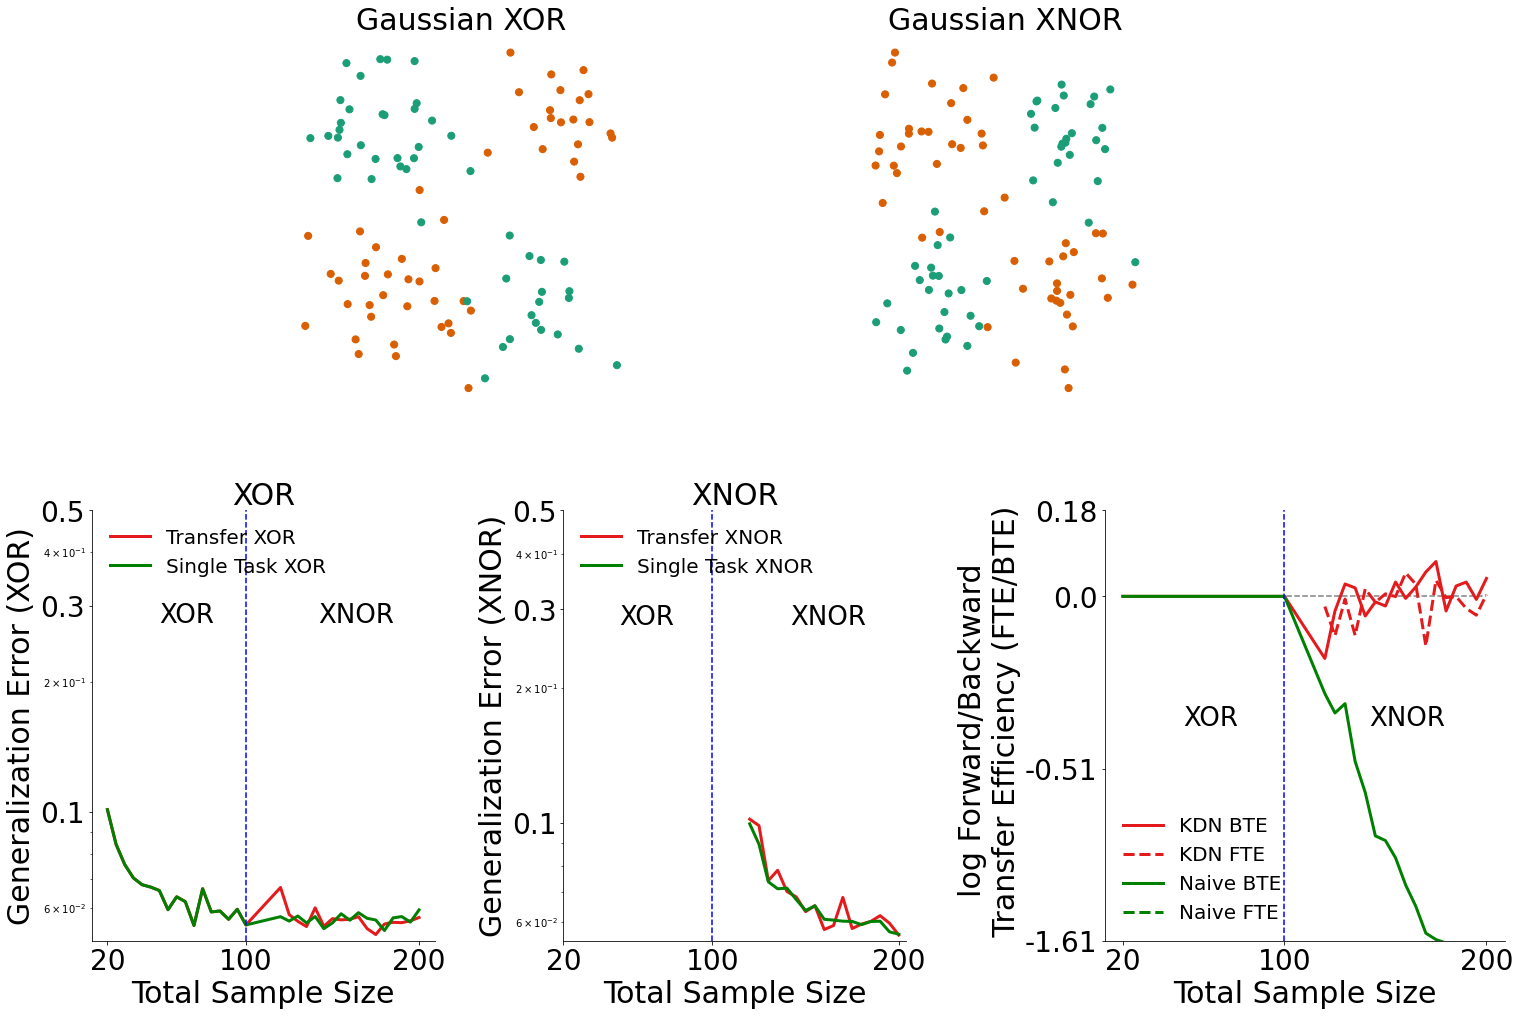

In [ ]:
# plot data
%matplotlib inline

task2_id = "xnor"
data = np.load(f'/content/gdrive/My Drive/kdn_proglearnfig_{task2_id}.npz')
for k in data.keys():
    print(k)

n_t1 = data['task1']
n_t2 = data['task2']
mean_error = data['mean_error']
mean_te = data['mean_te']

plot_error_and_eff(n_t1, n_t2, mean_error, mean_te, "XOR", "XNOR", angle=np.pi/2)

### Angle Sweep

In [ ]:
def bte_v_angle(mc_rep, task1_sample = 100, task2_sample = 100, angle_sweep = None, load=False):
    if load:
        data = np.load('/content/gdrive/My Drive/bte_v_angle_tmp.npz')
        mean_te = data['te']
        angle_sweep = data['angles']
        print("Loaded data!")
    elif angle_sweep == None:
        print("Hey, you need to supply some angles!")
        return
    else:
        mean_te = np.zeros(len(angle_sweep), dtype=float)

    for ii, angle in enumerate(angle_sweep):
        if mean_te[ii] != 0: continue #skip all versions that have been done
        error = np.array(
            Parallel(n_jobs=-1, verbose=0)(
                delayed(experiment)(
                    task1_sample,
                    task2_sample,
                    task2_angle=angle * np.pi / 180
                )
                for _ in range(mc_rep)
            )
        )

        mean_te[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])
        np.savez('/content/gdrive/My Drive/bte_v_angle_tmp.npz',
                   te = mean_te,
                   angles = angle_sweep)
        print(f"completed {angle} degrees")
    return mean_te

def plot_bte_v_angle(mean_te, mean_te2):
    angle_sweep = range(0, 90, 1)

    sns.set_context("talk")
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.plot(angle_sweep, np.log(mean_te2), linewidth=3, c="b", label="n = 50")
    ax.plot(angle_sweep, np.log(mean_te), linewidth=3, c="r", label="n = 100")
    ax.set_xticks([0, 15, 30, 45, 60, 75, 90])
    ax.set_xlabel("Angle of Rotation (Degrees)")
    ax.set_ylabel("log Backward Transfer Efficiency (XOR)")
    ax.hlines(0, 0, 90, colors="gray", linestyles="dashed", linewidth=1.5)

    ax.legend()

    #ax.set_yticks([0.9, 1, 1.1, 1.2])
    #ax.set_ylim(0.89, 1.22)
    #log_lbl = np.round(np.log([0.9, 1, 1.1, 1.2]), 2)
    #labels = [item.get_text() for item in ax.get_yticklabels()]

    #for ii, _ in enumerate(labels):
    #    labels[ii] = str(log_lbl[ii])

    #ax.set_yticklabels(labels)

    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)

Note: problem with sample sizes <10 when running forward transfer in parallel. Not reproducible in singular.


In [ ]:
angle_sweep = range(0, 90, 1)
task1_sample = 50
task2_sample = 50
mc_rep = 100  # reduce the number of repetitions for reduced runtime

#mean_te = bte_v_angle(mc_rep, task1_sample, task2_sample, angle_sweep)
mean_te = bte_v_angle(mc_rep, task1_sample, task2_sample, load=True)
np.savetxt('/content/gdrive/My Drive/kdn_prog_bte_50.txt',mean_te,
            header = f"completed {mc_rep} reps")

Loaded data!
completed 64 degrees
completed 65 degrees
completed 66 degrees
completed 67 degrees
completed 68 degrees


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


completed 69 degrees
completed 70 degrees
completed 71 degrees
completed 72 degrees
completed 73 degrees
completed 74 degrees
completed 75 degrees
completed 76 degrees
completed 77 degrees
completed 78 degrees
completed 79 degrees
completed 80 degrees
completed 81 degrees
completed 82 degrees
completed 83 degrees
completed 84 degrees
completed 85 degrees
completed 86 degrees
completed 87 degrees
completed 88 degrees
completed 89 degrees


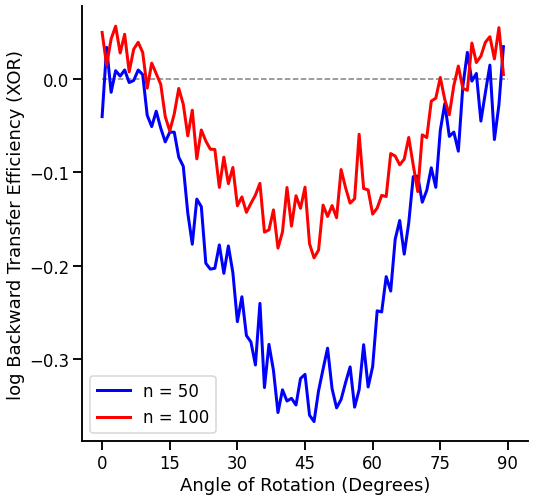

In [ ]:
# /content/gdrive/My Drive/kdn_prog_bte_1.txt: samples = 100, sweep = 1 degree
# /content/gdrive/My Drive/kdn_prog_bte_50.txt: samples = 50, sweep = 1 degree
mean_te = np.loadtxt('/content/gdrive/My Drive/kdn_prog_bte_1.txt')
mean_te2 = np.loadtxt('/content/gdrive/My Drive/kdn_prog_bte_50.txt')

plot_bte_v_angle(mean_te, mean_te2)

## Single Task Gaussian Transfer

Test transfer in only one direction.

### Functions

In [ ]:
#Source: source of gaussians
#Target: task checked for accuracy
#Test: new generated data used 
def st_transfer(n_source, n_target, n_test,
               label_source, label_target,
               angle_source, angle_target,
               overlap, dense_layer_nodes = 5,
               random_state = None):
    compile = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
    fit = {"epochs": 100, "batch_size": 32, "verbose": 0}

    # source data
    X_source, y_source = generate_gaussian_parity(n_source,
                                                cluster_std=overlap,
                                                angle_params=angle_source)
    
    # target training data
    X_target, y_target = generate_gaussian_parity(n_target,
                                                  cluster_std=overlap,
                                                  angle_params=angle_target)
    y_label = np.unique(y_target)

    # target testing data
    X_test, y_test = generate_gaussian_parity(n_test,
                                              cluster_std=overlap,
                                              angle_params=angle_target) 
    
    #create kdns
    nn_template = getNN(dense_layer_nodes, 2, **compile)

    kdn_1task = kdn(network = nn_template, verbose=False)
    kdn_1task.fit(X_target, y_target, label_target, **fit)
    
    kdn_rescale = kdn(network = nn_template, verbose=False)
    kdn_rescale.fit(X_source, y_source, label_source, **fit)
    kdn_rescale.polytope_sizes[label_target] = np.full([len(kdn_rescale.polytope_sizes[label_source]), 2], fill_value=np.nan)
    kdn_rescale.task_labels[label_target] = y_label
    kdn_rescale.class_priors[label_target] = np.array([np.sum(y_target == L)/len(y_target) for L in y_label])
    kdn_rescale.forward_transfer(X_target, y_target, label_target)

    kdn_2task = kdn(network = nn_template, verbose=False)
    kdn_2task.fit(X_source, y_source, label_source, **fit)
    kdn_2task.fit(X_target, y_target, label_target, **fit)

    X_transfer, y_transfer = kdn_2task.generate_data(n_target, label_target)
    kdn_2task.forward_transfer(X_transfer, y_transfer, label_target)

    #test_kdns
    errors = np.zeros(3, dtype=float)

    errors[0] = 1 - np.mean(kdn_1task.predict(X_test, label_target) == y_test) #Gaussians fit directly to Task2 only
    errors[1] = 1 - np.mean(kdn_rescale.predict(X_test, label_target) == y_test) #Gaussians fit to Task1, rescaled to task2
    errors[2] = 1 - np.mean(kdn_2task.predict(X_test, label_target) == y_test) #Rescaled gaussians + task2 gaussians both used

    return errors

def run2(mc_rep, n_test, n_task1, n_task2,
         label_source = "XOR", label_target = "RXOR",
         angle_source = 0, angle_target = np.pi/4,
         overlap = 0.25):
    #try:
    #    data = np.load('/content/gdrive/My Drive/kdn_prog_err.npz')
    #    mean_error = data['arr_0']
    #    data = np.load('/content/gdrive/My Drive/kdn_prog_transfer.npz')
    #    mean_te = data['arr_0']
    #    print("Loaded successfully!")
    #except:
    mean_error = np.zeros((3, len(n_task1), len(n_task2)))
    mean_te = np.zeros((2, len(n_task1), len(n_task2)))

    for i, n1 in enumerate(n_task1):
        if mean_error[0, i, 0] != 0: continue #skip all versions that have been done
        print(f'\nstarting to compute {n1} {label_source}')
        for j, n2 in enumerate(n_task2):
            print(f'starting to compute {n2} {label_target}')
            error = np.array([st_transfer(n1, n2, n_test, label_source, label_target, angle_source, angle_target, overlap) for _ in range(mc_rep)])

            mean_error[:, i, j] = np.mean(error, axis=0)
            mean_te[0, i, j] = np.mean(error[:, 0]) / np.mean(error[:, 1])
            mean_te[1, i, j] = np.mean(error[:, 0]) / np.mean(error[:, 2])
        
        np.savez('/content/gdrive/My Drive/kdn_prog_err.npz',
                   mean_error,
                   header=f'Completed through {n1} {label_source}')
        np.savez('/content/gdrive/My Drive/kdn_prog_transfer.npz',
                   mean_te,
                   header=f'Completed through {n1} {label_source}')

    return mean_error, mean_te

def get_posteriors(network, label):
    #define grids
    p = np.arange(-3, 3, step=0.01)
    q = np.arange(-3, 3, step=0.01)
    xx, yy = np.meshgrid(p, q)
    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
    posteriors = network.predict_proba(grid_samples, label)
    posteriors = posteriors[:,0].reshape(600,600)

    return(posteriors)

In [ ]:
# define hyperparameters:
mc_rep = 10
n_test = 1000
overlap = 0.25
n_t1 = np.arange(50, 501, step=50).astype(int)
n_t2 = np.arange(50, 501, step=50).astype(int)

mean_error, mean_te = run2(mc_rep, n_test, n_t1, n_t2, overlap = overlap,
                           angle_target = np.pi/4, label_target = "RXOR")

np.savez('/content/gdrive/My Drive/kdn_prog_RXOR.npz', task1 = n_t1, task2 = n_t2, mean_error = mean_error, mean_te = mean_te)

### Plot Transfer Efficiencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

data = np.load('/content/gdrive/My Drive/kdn_prog_XNOR.npz')
for k in data.keys():
    print(k)

n_t1 = data['task1']
n_t2 = data['task2']
mean_error = data['mean_error']
mean_te = data['mean_te']

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
task1
task2
mean_error
mean_te


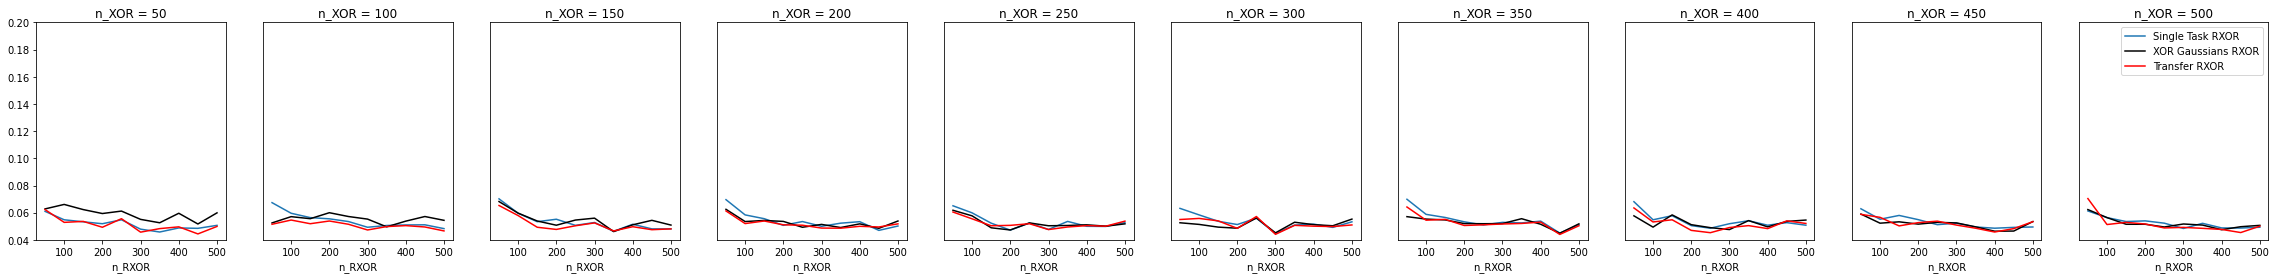

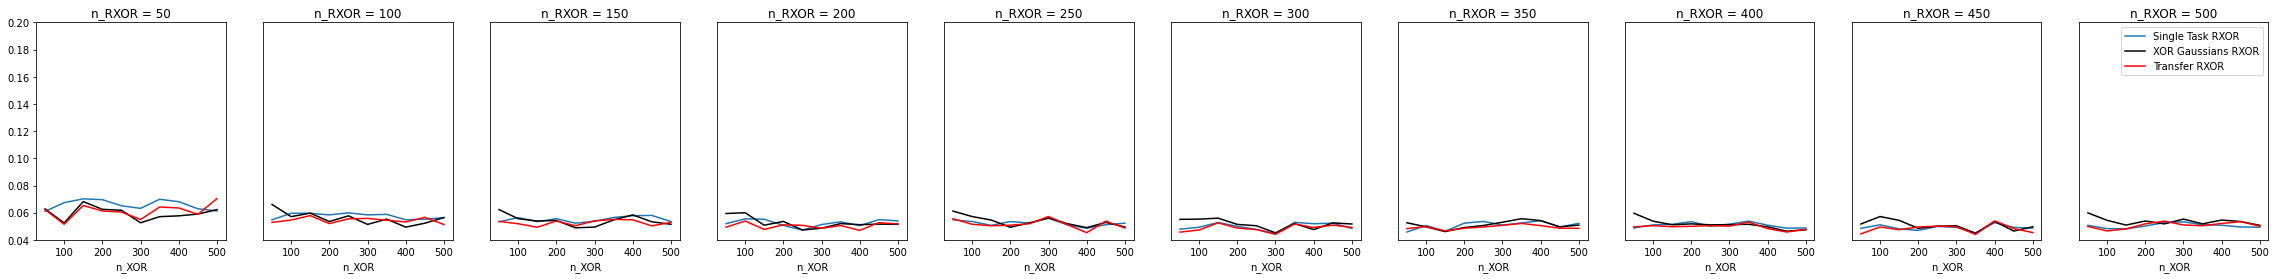

In [ ]:
task1 = "XOR"
task2 = "RXOR"
algorithms = [f"Single Task {task2}",
              f"{task1} Gaussians {task2}",
              f"Transfer {task2}"]

fig1, ax1 = plt.subplots(1, 10, figsize=(40, 4))
for i, n1i in enumerate(n_t1):
    ax1[i].plot(n_t1, mean_error[0, i, :], label=algorithms[0])
    ax1[i].plot(n_t1, mean_error[1, i, :], label=algorithms[1], color="black")
    ax1[i].plot(n_t1, mean_error[2, i, :], label=algorithms[2], color="red")
    ax1[i].set_ylim(0.04, 0.20)
    ax1[i].set_title(f"n_{task1} = {n1i}")
    ax1[i].set_xlabel(f"n_{task2}")
    if i > 0:
        ax1[i].tick_params(axis="y", which="both", left=False, labelleft=False)
ax1[9].legend()

fig2, ax2 = plt.subplots(1, 10, figsize=(40, 4))
for j, n2j in enumerate(n_t2):
    ax2[j].plot(n_t2, mean_error[0, :, j], label=algorithms[0])
    ax2[j].plot(n_t2, mean_error[1, :, j], label=algorithms[1], color="black")
    ax2[j].plot(n_t2, mean_error[2, :, j], label=algorithms[2], color="red")
    ax2[j].set_ylim(0.04, 0.20)
    ax2[j].set_title(f"n_{task2} = {n2j}")
    ax2[j].set_xlabel(f"n_{task1}")
    if j > 0:
        ax2[j].tick_params(axis="y", which="both", left=False, labelleft=False)
ax2[9].legend()

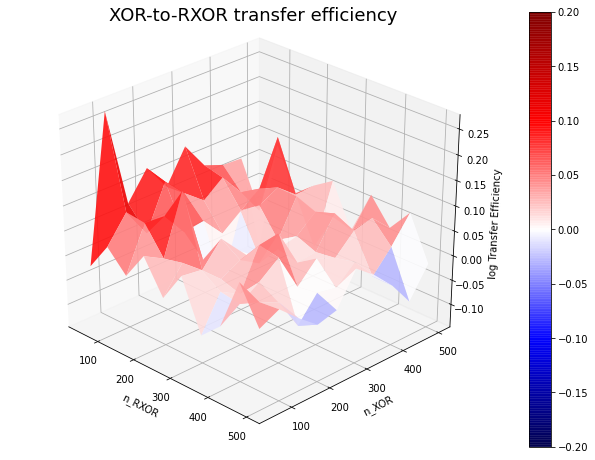

In [ ]:
from mpl_toolkits import mplot3d
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

X, Y = np.meshgrid(n_t1, n_t2)

vmin = -0.2
vmax = 0.2
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig = plt.figure(figsize=(11, 8))
ax = plt.axes(projection='3d')

im = ax.plot_surface(X, Y, np.log(mean_te[1, :, :]),
                     cmap="seismic", norm=norm, alpha=0.9,
                     label="log Transfer Efficiency")
ax.set_xlabel('n_RXOR')
ax.set_ylabel('n_XOR')
ax.set_zlabel('log Transfer Efficiency');
ax.set_title("XOR-to-RXOR transfer efficiency", y=1.05, fontsize=18)
#add colorbar
fig.colorbar(im)

ax.view_init(30, 315)

In [ ]:
print(X)
print(Y)
print(mean_te[1, :, :])

### Visualize Posteriors

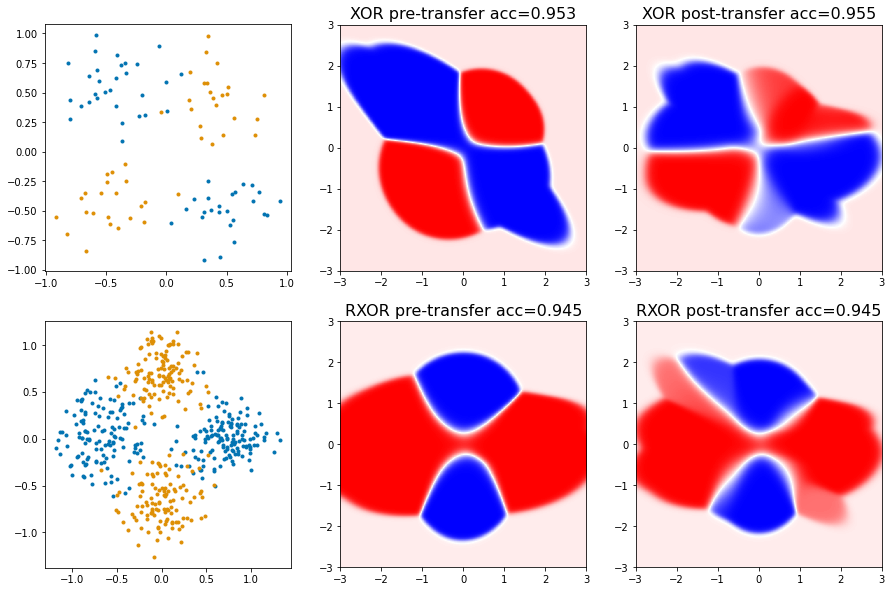

In [ ]:
compile = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
fit = {"epochs": 100, "batch_size": 32, "verbose": 0}
nn_template = getNN(5, 2, **compile)

X_source, y_source = generate_gaussian_parity(100)
X_target, y_target = generate_gaussian_parity(500, angle_params=np.pi/4)

X_s_transfer, y_s_transfer = generate_gaussian_parity(100)
X_t_transfer, y_t_transfer = generate_gaussian_parity(100, angle_params=np.pi/4)
#X_s_transfer = X_source
#X_t_transfer = X_target
#y_s_transfer = y_source
#y_t_transfer = y_target

X_s_test, y_s_test = generate_gaussian_parity(1000)
X_t_test, y_t_test = generate_gaussian_parity(1000, angle_params=np.pi/4)

label_source = "XOR"
label_target = "RXOR"

kdn_2task = kdn(network = nn_template, verbose=False)
kdn_2task.fit(X_source, y_source, label_source, **fit)
kdn_2task.fit(X_target, y_target, label_target, **fit)
post_xor = get_posteriors(kdn_2task, label_source)
post_rxr = get_posteriors(kdn_2task, label_target)
xor_acc = np.mean(kdn_2task.predict(X_s_test, label_source) == y_s_test)
rxr_acc = np.mean(kdn_2task.predict(X_t_test, label_target) == y_t_test)

fig1, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0,0] = plot_2dsim(X_source, y_source, ax=ax[0,0])
ax[1,0] = plot_2dsim(X_target, y_target, ax=ax[1,0])

ax[0, 1].imshow(
    post_xor,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0, 1].set_title(f"XOR pre-transfer acc={xor_acc}", fontsize=16)
ax[0, 1].set_aspect("equal")

ax[1, 1].imshow(
    post_rxr,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1, 1].set_title(f"RXOR pre-transfer acc={rxr_acc}", fontsize=16)
ax[1, 1].set_aspect("equal")

kdn_2task.forward_transfer(X_s_transfer, y_s_transfer, label_source)
kdn_2task.forward_transfer(X_t_transfer, y_t_transfer, label_target)
post_xor2 = get_posteriors(kdn_2task, label_source)
post_rxr2 = get_posteriors(kdn_2task, label_target)
xor2_acc = np.mean(kdn_2task.predict(X_s_test, label_source) == y_s_test)
rxr2_acc = np.mean(kdn_2task.predict(X_t_test, label_target) == y_t_test)

ax[0, 2].imshow(
    post_xor2,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0, 2].set_title(f"XOR post-transfer acc={xor2_acc}", fontsize=16)
ax[0, 2].set_aspect("equal")

ax[1, 2].imshow(
    post_rxr2,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1, 2].set_title(f"RXOR post-transfer acc={rxr2_acc}", fontsize=16)
ax[1, 2].set_aspect("equal")

## Miscellaneous Experiments


### Cluster standard deviation
Test parameters to determine best stdev for generated distribution

In [ ]:
def plot_accuracy(sample_size, pct_errs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    color_list = [(1.0, 0.0, 0.0), (0.0, 0.0, 0.0)]
    color_list.extend(sns.color_palette("Set1")[1:])

    for i, err in enumerate(pct_errs):
        ax.plot(sample_size, np.mean(err, axis=1), c=color_list[i], label=labels[i])
        ax.fill_between(
            sample_size,
            np.quantile(err, 0.25, axis=1),
            np.quantile(err, 0.75, axis=1),
            facecolor=color_list[i],
            alpha=0.3,
        )
    
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)

    #ax.set_xscale("log")
    ax.set_xlabel("Sample size")
    ax.set_ylabel("Percent Error")
    ax.legend(frameon=False)

#Bayes Error Test
n_xor = np.arange(20, 301, step=20).astype(int)
n_train = 500
reps = 10
shape = (len(n_xor), reps)

overlaps = np.arange(5, 11, step=1)*0.05
nn_template = getNN(5, 2, **compile_kwargs)
errors = []

for o in overlaps:
    accuracy = []
    print(f"Testing with cluster_std {o}")
    for n in n_xor:
        for r in range(reps):
            X_train, y_train = generate_gaussian_parity(n, cluster_std = o, angle_params = np.pi/4)
            X_test, y_test = generate_gaussian_parity(n_train, cluster_std = o, angle_params = np.pi/4)
            kdn_bayes = kdn(network = nn_template)
            kdn_bayes.fit(X_train, y_train, "RXOR", **fit_kwargs)
            y_hat = kdn_bayes.predict(X_test, "RXOR")
            accuracy.append(np.mean(y_hat == y_test))
    errors.append(1 - np.array(accuracy).reshape(shape))
    

Testing with cluster_std 0.25
Testing with cluster_std 0.30000000000000004
Testing with cluster_std 0.35000000000000003
Testing with cluster_std 0.4
Testing with cluster_std 0.45
Testing with cluster_std 0.5


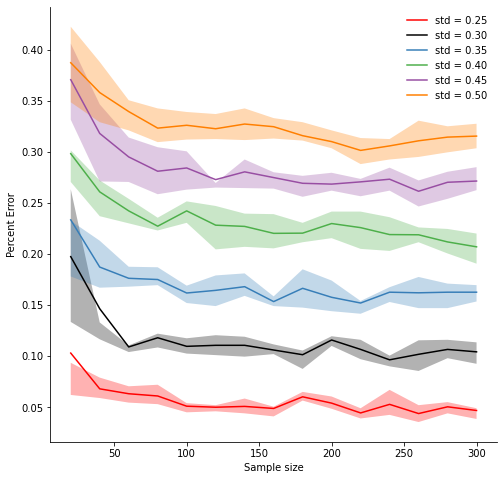

In [ ]:
plot_accuracy(n_xor, errors, [f"std = {o:.2f}" for o in overlaps])


### Generate Data
Visualize original vs generated data at various sizes of original data

Text(0, 0.5, 'Generated Data')

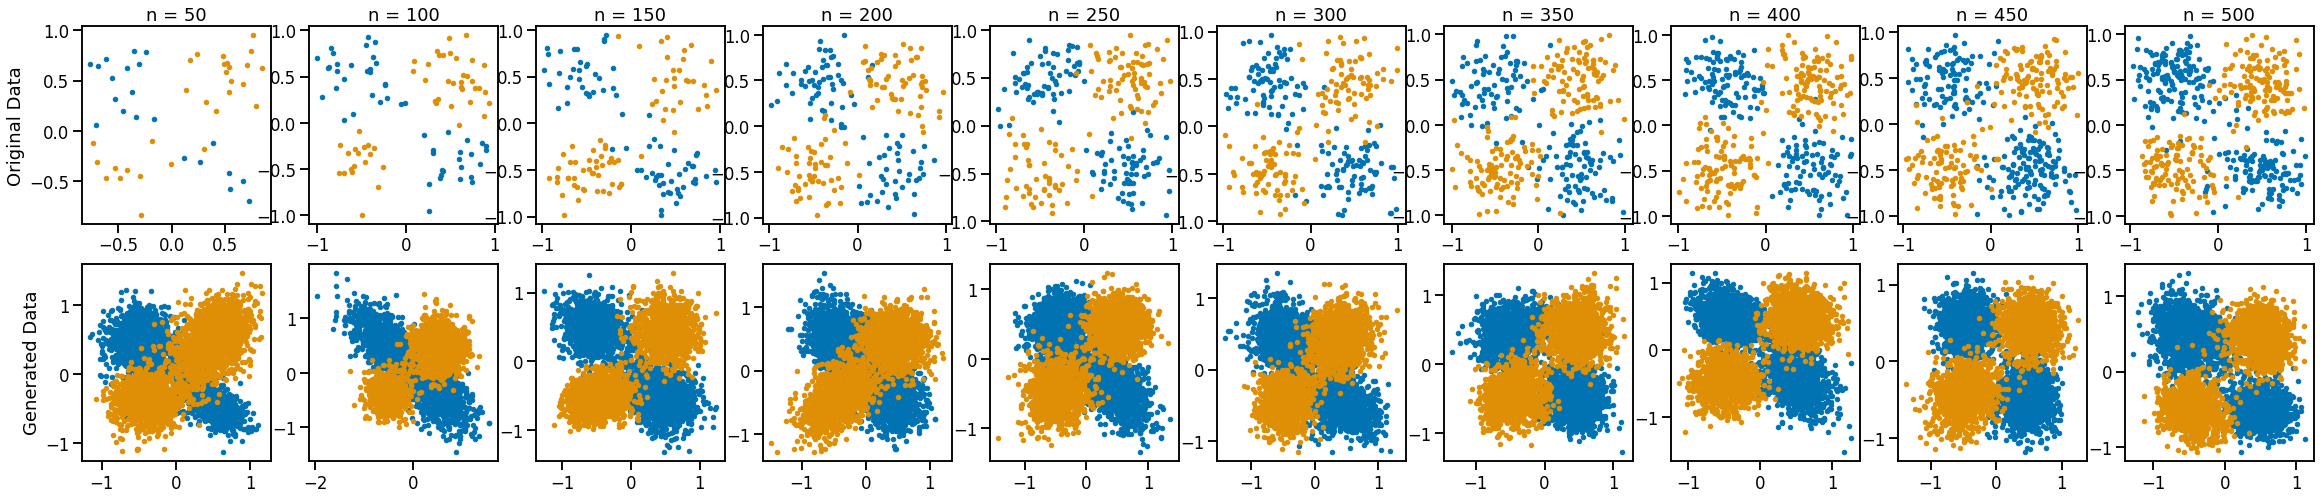

In [ ]:
n_source = np.arange(50, 501, step=50)
n_generate = 5000

compile = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
fit = {"epochs": 100, "batch_size": 32, "verbose": 0}

fig3, ax3 = plt.subplots(2, 10, figsize=(40, 8))
nn_template = getNN(5, 2, **compile)
for i, n in enumerate(n_source):
    X1, y1 = generate_gaussian_parity(n,cluster_std=0.25,angle_params=0)
    X2, y2 = generate_gaussian_parity(n,cluster_std=0.25,angle_params=np.pi/4)
    
    kdn_2task = kdn(network = nn_template, verbose=False)
    kdn_2task.fit(X1, y1, label_source, **fit)
    kdn_2task.fit(X2, y2, label_target, **fit)

    X_transfer, y_transfer = kdn_2task.generate_data(5000, 0, False)
    plot_2dsim(X1, y1, ax=ax3[0, i])
    plot_2dsim(X_transfer, y_transfer, ax=ax3[1, i])
    ax3[0, i].set_title(f'n = {n}')

ax3[0, 0].set_ylabel("Original Data")
ax3[1, 0].set_ylabel("Generated Data")